In [2]:
#!/usr/bin/env python



In [3]:
import pandas as pd
import numpy as np

#import pandas.io.sql as pd_sql

from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

import datetime
import calendar


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [4]:

convert_dict = {'trip_seconds': 'float32', 
                'trip_miles': 'float32', 
                'dropoff_community_area': 'float32',
                'fare': 'float32', 
                'trip_total': 'float32',
                'dropoff_centroid_latitude': 'float32',
                'dropoff_centroid_longitude': 'float32',
                'pickup_community_area': 'float32',
                'pickup_centroid_latitude': 'float32',
                'pickup_centroid_longitude': 'float32'}
  


In [5]:
engine = create_engine('sqlite:///TaxiTrips.db')
conn = engine.connect().execution_options(stream_results=True)
    
chunk_list = []
for chunk_dataframe in pd.read_sql(
            'SELECT * FROM taxi_2021 WHERE dropoff_community_area != "None" AND fare != "None" AND trip_total !="None" AND payment_type != "None" AND company != "None" AND dropoff_centroid_latitude != "None" AND dropoff_centroid_longitude != "None" AND pickup_community_area != "None" AND pickup_centroid_latitude != "None" AND pickup_centroid_longitude != "None" AND trip_seconds!=0 and trip_miles !=0' , conn, chunksize=1000):
    
    
    #print(f"Got dataframe w/{len(chunk_dataframe)} rows")
        # ... do something with dataframe ...
        
   
    chunk_list.append(chunk_dataframe)

df_concat = pd.concat(chunk_list)    

In [6]:
df =df_concat.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1843982 entries, 0 to 981
Data columns (total 14 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   trip_id                     object
 1   trip_start_timestamp        object
 2   trip_seconds                object
 3   trip_miles                  object
 4   dropoff_community_area      object
 5   fare                        object
 6   trip_total                  object
 7   payment_type                object
 8   company                     object
 9   dropoff_centroid_latitude   object
 10  dropoff_centroid_longitude  object
 11  pickup_community_area       object
 12  pickup_centroid_latitude    object
 13  pickup_centroid_longitude   object
dtypes: object(14)
memory usage: 211.0+ MB


In [7]:
df = df.astype(convert_dict)
    
df['trip_start_timestamp'] = pd.to_datetime(df["trip_start_timestamp"], format="%Y-%m-%dT%H:%M:%S.%f")
df['trip_date'] =(df['trip_start_timestamp']).dt.date
df['trip_day'] = (df['trip_start_timestamp']).dt.dayofweek
df['trip_start_time'] =(df['trip_start_timestamp'].dt.time)
df['trip_month'] = (df['trip_start_timestamp'].dt.month)

df['trip_period'] = np.digitize(df['trip_start_timestamp'].dt.hour, [0,5,10,16,20])

Unusual data points: 
-trips with short distance, long duration
-trips with short duration, long distance 
-trips with low fare, long distance
-trips with short distance, high fares
-trips with short duration, high fares

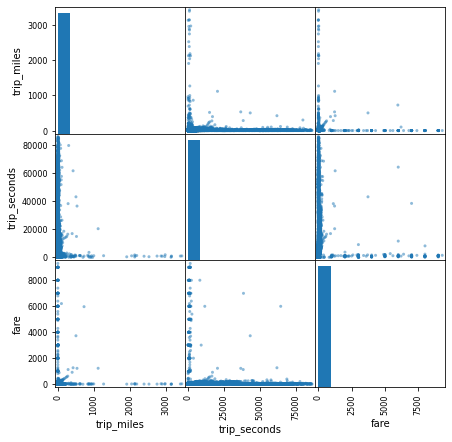

In [331]:
pd.plotting.scatter_matrix(frame = df[['trip_miles', 'trip_seconds','fare']], figsize=(7,7));


[Text(0.5, 1.0, 'Trip Miles vs Duration(in seconds)')]

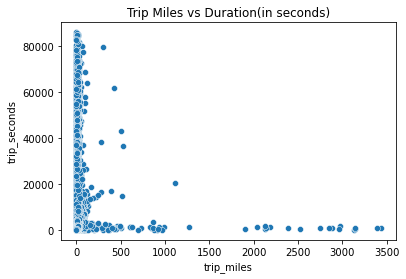

In [335]:
sns.scatterplot(x='trip_miles',y='trip_seconds',data=df).set(title='Trip Miles vs Duration(in seconds)')

[Text(0.5, 1.0, 'Trip Fares vs Miles')]

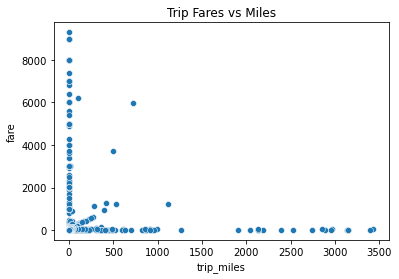

In [332]:
sns.scatterplot(x='trip_miles',y='fare',data=df).set(title='Trip Fares vs Miles')

[Text(0.5, 1.0, 'Trip Duration(in seconds) vs Miles')]

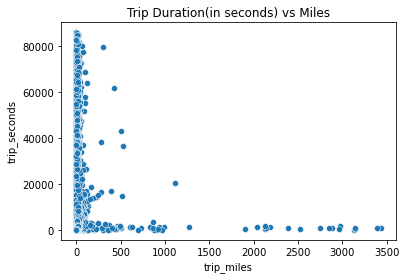

In [333]:
sns.scatterplot(x='trip_miles',y='trip_seconds',data=df).set(title='Trip Duration(in seconds) vs Miles')

In [8]:
df[['fare', 'trip_miles', 'trip_seconds']].describe()

,fare,trip_miles,trip_seconds
count,1.843982e+06,1.843982e+06,1.843982e+06
mean,2.019852e+01,5.954370e+00,1.182390e+03
std,5.488513e+01,1.091782e+01,1.749427e+03
min,0.000000e+00,1.000000e-02,1.000000e+00
25%,7.750000e+00,1.140000e+00,4.800000e+02
50%,1.450000e+01,3.100000e+00,9.000000e+02
75%,3.000000e+01,1.001000e+01,1.568000e+03
max,9.300470e+03,3.430530e+03,8.613700e+04


In [251]:
#longest 5 trip duration (trips longer than 86400 minutes are excluded in the original data)
df['trip_seconds'].nlargest(5)


745    86137.0
661    85825.0
789    85554.0
379    85303.0
634    85077.0
Name: trip_seconds, dtype: float32

In [337]:
#The number of trips less than 5 seconds
len(df[df['trip_seconds']<5])

1621

In [338]:
#The number of trips less than 5 seconds and fares greater than $20
len(df[(df['trip_seconds']<5) &(df['fare']>20)])

161

In [29]:
#New variable: speed, miles per hour
df['trip_mph'] = (df['trip_miles']*3600)/df['trip_seconds']


In [278]:
#There are extremely high speed values 
df['trip_mph'].sort_values(ascending=False)

600    865656.000000
158    129557.382812
99      91044.000000
324     66024.000000
155     64800.000000
           ...      
893         0.000664
692         0.000513
995         0.000513
583         0.000505
343         0.000491
Name: trip_mph, Length: 1843982, dtype: float32

In [340]:
#There are 3015 trips with mph much higher than the legal speed limit
len(df[df['trip_mph']>80])

3015

In [341]:
#There are 182182 trips with mph less than 5 mph
len(df[(df['trip_mph']<5)])

182182

In [325]:
#minimum fare per trip
df['min_fare'] = df['trip_miles']*2.25 + df['trip_seconds']*(0.2)/36 +3.25

In [326]:
#Drop rows with fare lower than min_fate
len( df[df['fare']>=df['min_fare']])

183917

In [327]:
df['fare_ph'] = df['fare']*3600/df['trip_seconds']

In [328]:
df['fare_ph'].sort_values(ascending = False)

29     1.212120e+06
530    3.409088e+05
993    3.116890e+05
683    2.628000e+05
716    2.321089e+05
           ...     
488    0.000000e+00
223    0.000000e+00
827    0.000000e+00
298    0.000000e+00
671    0.000000e+00
Name: fare_ph, Length: 1843982, dtype: float64

In [ ]:
#Trip duration is <5 minutes
#len(df[(df['trip_seconds']==1) &(df['trip_miles']>0)])
#len(df[(df['trip_seconds']==0)])

In [167]:
# Write to csv
#df.to_csv('data.csv')

In [263]:
#Trip duration is <5 minutes
#len(df[(df['trip_seconds']==1) &(df['trip_miles']>0)])
#len(df[(df['trip_seconds']==0)])

393

In [287]:
#the count of trips less than 5 mph
len(df[(df['trip_mph']<5)])

182182

In [342]:
#Unusual data points: short trip(in seconds) with large miles
len(df[(df['trip_seconds']<=1) &(df['trip_miles']>0) & df['fare']>0])

393

In [289]:
#There are 2839 trips with zero fare
len(df[df['fare']==0 ])

2839

In [294]:
df['trip_miles'].mean()

5.954370498657227

In [295]:
#Trips with higher than 3500 miles were excluded from the original dataset, though still there are long distance trips
df['trip_miles'].nlargest(10)

269    3430.530029
987    3389.570068
776    3142.889893
103    3142.260010
158    3130.969971
720    2969.709961
371    2958.449951
820    2886.649902
652    2854.780029
417    2744.649902
Name: trip_miles, dtype: float32

In [344]:
df.columns


Index(['trip_id', 'trip_start_timestamp', 'trip_seconds', 'trip_miles',
       'dropoff_community_area', 'fare', 'trip_total', 'payment_type',
       'company', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
       'pickup_community_area', 'pickup_centroid_latitude',
       'pickup_centroid_longitude', 'trip_day', 'trip_start_time',
       'trip_month', 'min_fare', 'fare_ph', 'trip_mph'],
      dtype='object')

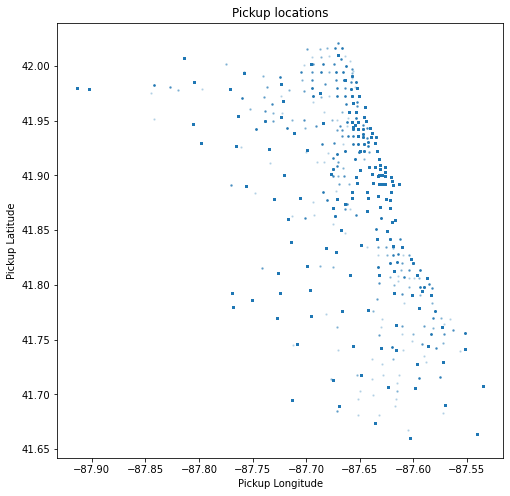

In [346]:
def pickup_scatter(t):
    plt.scatter(t['pickup_centroid_longitude'], t['pickup_centroid_latitude'], s=2, alpha=0.2)
    plt.xlabel('Pickup Longitude')
    plt.ylabel('Pickup Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(8, 8))
pickup_scatter(df)

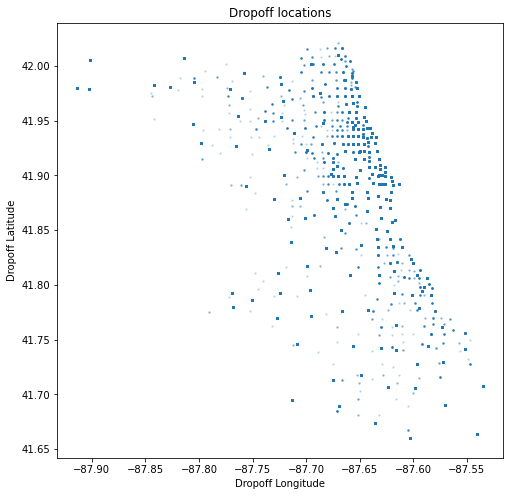

In [348]:
def dropoff_scatter(t):
    plt.scatter(t['dropoff_centroid_longitude'], t['dropoff_centroid_latitude'], s=2, alpha=0.2)
    plt.xlabel('Dropoff Longitude')
    plt.ylabel('Dropoff Latitude')
    plt.title('Dropoff locations')
    
plt.figure(figsize=(8, 8))
dropoff_scatter(df)

In [9]:
df_date = df.groupby('trip_date').trip_id.count().reset_index()

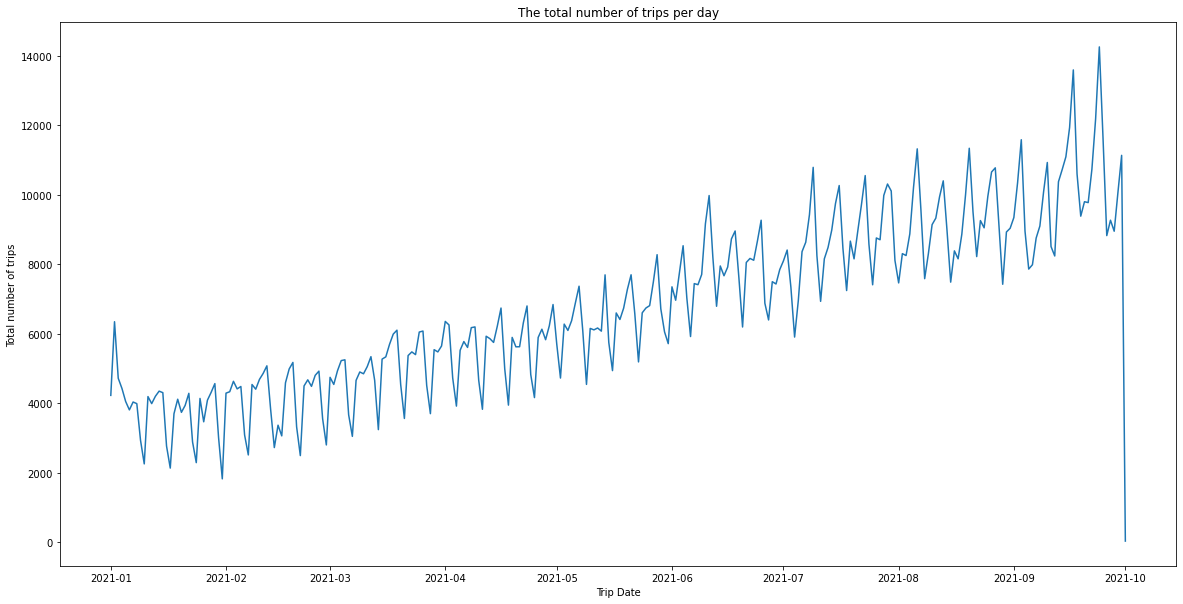

In [18]:
plt.figure(figsize = (20,10))

ax = sns.lineplot(data=df_date, x="trip_date", y="trip_id")

#specfiy axis labels
ax.set(xlabel='Trip Date',
       ylabel='Total number of trips',
       title='The total number of trips per day')

#display 
plt.show()

In [32]:
df_period = df.groupby(['trip_date','trip_period']).trip_id.count().reset_index()

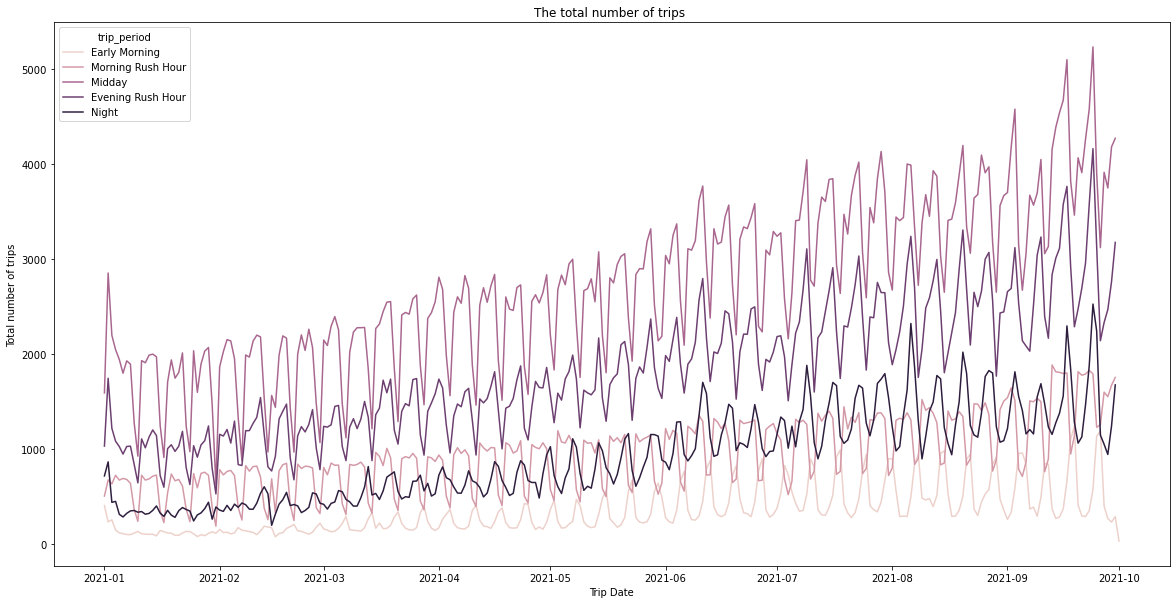

In [37]:
plt.figure(figsize = (20,10))

ax = sns.lineplot(data=df_period, x="trip_date", y="trip_id",hue='trip_period')

#specfiy axis labels
ax.set(xlabel='Trip Date',
       ylabel='Total number of trips',
       title='The total number of trips ')

# replace labels
new_labels = ['Early Morning', 'Morning Rush Hour','Midday','Evening Rush Hour','Night']
for t, l in zip(ax.legend_.texts, new_labels):
    t.set_text(l)




#display 
plt.show()

In [ ]:
df_period = df.groupby(['trip_date','trip_period']).trip_id.count().reset_index()

In [38]:
df_avg_times = df.groupby(['trip_day']).trip_seconds.mean().reset_index()

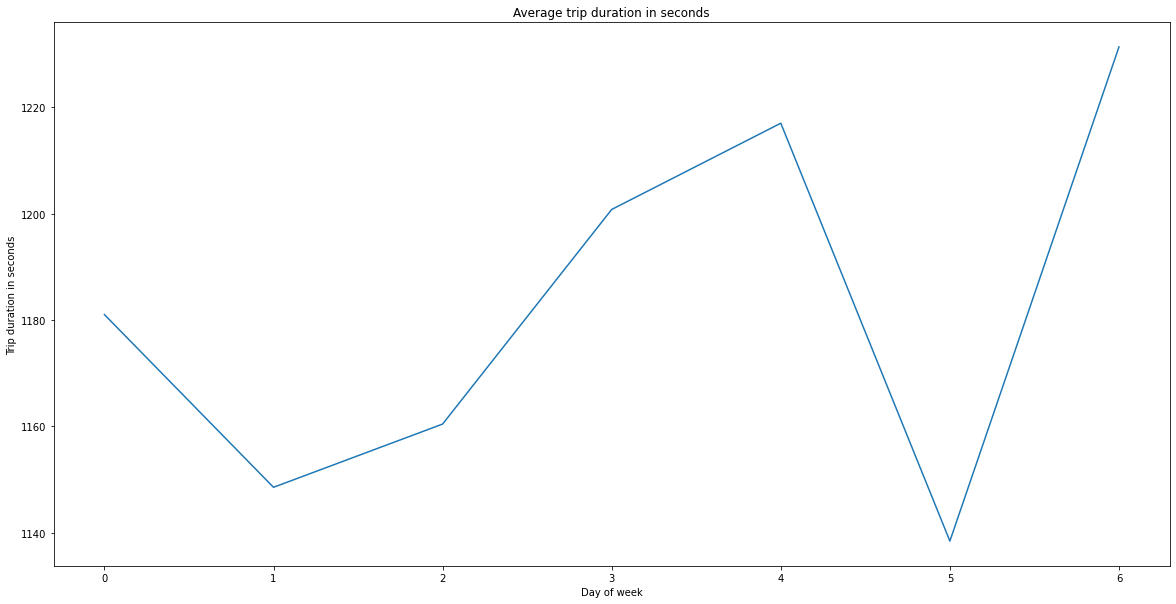

In [47]:
plt.figure(figsize = (20,10))

ax = sns.lineplot(data=df_avg_times, x="trip_day", y="trip_seconds")

#specfiy axis labels
ax.set(xlabel='Day of week',
       ylabel='Trip duration in seconds',
       title='Average trip duration in seconds')

# replace labels
#new_labels = ['Monday', 'Tuesday','Wednesday','Thursday','Friday', 'Saturday', 'Sunday']
#for t, l in zip(ax.axes.flat[0].get_legend(), new_labels):
#    t.set_text(l)

#leg = g.axes.flat[0].get_legend()
#display 
plt.show()

KeyboardInterrupt: 

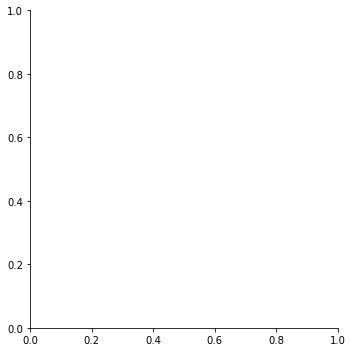

In [50]:
 #sns.catplot(x="trip_seconds", y="trip_seconds", hue="trip_day", data=df)